## Version History
- 1.0.0 - original tutorial code, with custom dataset (https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/)
- 1.0.1 - different code structure to try multivariate and multi-step (https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/)

In [172]:
import pandas as pd
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import numpy as np
from numpy import array, hstack
import matplotlib.pyplot as plt
import os, math
from keras import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import EarlyStopping

In [2]:
os.listdir()

['.ipynb_checkpoints',
 'multivariate_lstm_1.0.0.ipynb',
 'multivariate_lstm_1.0.1.ipynb',
 'multivariate_lstm_sample.txt']

In [79]:
def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequence)):
        # Finding the end of the pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        
        # Checking if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
            
        # Gather input and output parts of pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix: out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [69]:
# load data
dataset = pd.read_csv('multivariate_lstm_sample.txt', sep='\t', header=None, usecols=[0,1,2,3],
                          engine='python', index_col=0)

In [70]:
print(dataset)

                 1          2           3
0                                        
0.0000    2.781212  92.627635  457.682373
0.0004    2.736633  92.678534  457.508240
0.0008    2.704369  92.729433  458.658142
0.0012    2.677361  92.780331  459.100617
0.0016    2.767273  92.831230  458.402374
...            ...        ...         ...
11.9980  24.099121  81.195835  281.338654
11.9984  23.854050  81.183502  281.634705
11.9988  23.012009  81.171169  290.019440
11.9992  21.645805  81.158836  289.916809
11.9996  19.967583  81.146503  292.720154

[30000 rows x 3 columns]


In [71]:
# manually specify column names
dataset.columns = ['pressure', 'temperature', 'mass flux']
dataset.index.name = 'time'

In [72]:
print(dataset['pressure'].values)

[ 2.78121185  2.7366333   2.70436859 ... 23.01200867 21.64580536
 19.9675827 ]


In [73]:
# mark all NA values with 0
dataset.fillna(0, inplace=True)

In [74]:
pressure_array = dataset['pressure'].values
temperature_array = dataset['temperature'].values
mass_array = dataset['mass flux'].values

In [75]:
scaler = MinMaxScaler(feature_range=(0,1))
pressure_scaled = scaler.fit_transform(pressure_array.reshape(-1,1))
temperature_scaled = scaler.fit_transform(temperature_array.reshape(-1,1))
mass_scaled = scaler.fit_transform(mass_array.reshape(-1,1))

In [76]:
pressure_scaled = pressure_scaled.reshape((len(pressure_scaled), 1))
temperature_scaled = temperature_scaled.reshape((len(temperature_scaled), 1))
mass_scaled = mass_scaled.reshape((len(mass_scaled), 1))

In [77]:
full_dataset_scaled = hstack((pressure_scaled, temperature_scaled, mass_scaled))

In [189]:
n_steps_in = 200
n_steps_out = 200
X, y = split_sequence(full_dataset_scaled, n_steps_in, n_steps_out)
n_features = X.shape[2]

print(X.shape, y.shape)

es = EarlyStopping(patience=4, monitor='loss')

(29601, 200, 3) (29601, 200, 3)


In [190]:
# define model
model = Sequential()
model.add(LSTM(n_steps_in, activation='relu', return_sequences=True, input_shape=(n_steps_in, n_features)))
model.add(LSTM(n_steps_in, activation='relu', return_sequences=True))
model.add(Dense(n_features))
model.compile(optimizer='adam', loss='mse')

In [191]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_21 (LSTM)               (None, 200, 200)          163200    
_________________________________________________________________
lstm_22 (LSTM)               (None, 200, 200)          320800    
_________________________________________________________________
dense_11 (Dense)             (None, 200, 3)            603       
Total params: 484,603
Trainable params: 484,603
Non-trainable params: 0
_________________________________________________________________


In [192]:
# fit model
history = model.fit(X, y, epochs=30, verbose=1, callbacks=[es], batch_size=100)

Epoch 1/30
29601/29601 [==============================] - 3089s 104ms/step - loss: 0.0089
Epoch 2/30
29601/29601 [==============================] - 3196s 108ms/step - loss: 0.0053
Epoch 3/30
29601/29601 [==============================] - 3017s 102ms/step - loss: 0.0050
Epoch 4/30
29601/29601 [==============================] - 2963s 100ms/step - loss: 0.0048
Epoch 5/30
29601/29601 [==============================] - 3136s 106ms/step - loss: 0.0048
Epoch 6/30
 3200/29601 [==>...........................] - ETA: 48:18 - loss: 0.0048

KeyboardInterrupt: 

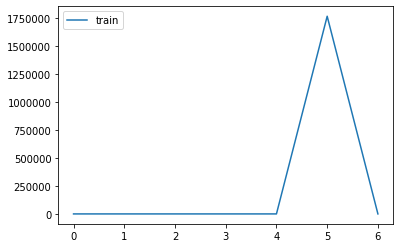

In [180]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.legend()
plt.show()

In [96]:
# make a prediction
yhat = model.predict(X)

In [97]:
print(yhat)

[[[0.10879463 0.30420738 0.5470313 ]
  [0.10551037 0.3177493  0.55297774]
  [0.10515167 0.32245636 0.5596253 ]
  ...
  [0.08964567 0.41505703 0.58982414]
  [0.08969187 0.41565913 0.58983916]
  [0.08975307 0.41612488 0.5896559 ]]

 [[0.10881777 0.3049144  0.54699326]
  [0.10557213 0.3187547  0.5533954 ]
  [0.10522395 0.32346305 0.5600776 ]
  ...
  [0.08969186 0.4156591  0.58983916]
  [0.08975308 0.41612488 0.5896559 ]
  [0.08984634 0.41648436 0.58938676]]

 [[0.10888803 0.30593398 0.5474996 ]
  [0.10560381 0.3197418  0.55379635]
  [0.1052434  0.3243909  0.5603028 ]
  ...
  [0.08975306 0.41612488 0.5896559 ]
  [0.08984634 0.4164843  0.58938676]
  [0.08997349 0.41679642 0.58907413]]

 ...

 [[0.10207015 0.14854679 0.51147413]
  [0.09998213 0.14676775 0.49950045]
  [0.09880756 0.14358614 0.49490404]
  ...
  [0.0914882  0.13025226 0.4964254 ]
  [0.09208974 0.13026151 0.49656317]
  [0.09269131 0.13026191 0.49657696]]

 [[0.10202552 0.14893997 0.5122813 ]
  [0.09978047 0.14753188 0.501013  ]


In [104]:
print(yhat[0].shape)
print(X[100:200][0].shape)

(100, 3)
(100, 3)


In [ ]:
yhat_pressure_

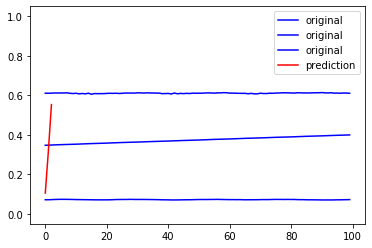

In [128]:
plt.plot(full_dataset_scaled[100:200], color='blue', label='original')
plt.plot(yhat[0][1], color='red', label='prediction')
plt.plot(0)
plt.plot(1)
plt.legend()
plt.show()

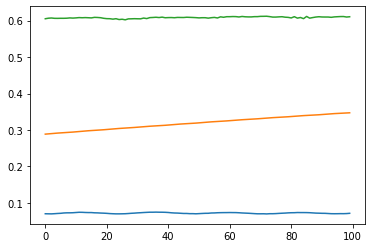

In [114]:
plt.plot(X[1][:])

In [115]:
print(X.shape)

(29801, 100, 3)


(30000, 3)


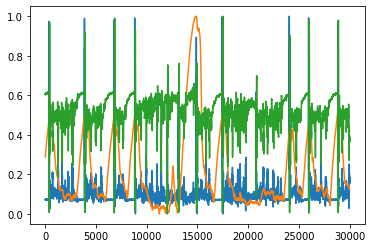

In [117]:
plt.plot(full_dataset_scaled)
print(full_dataset_scaled.shape)

In [140]:
inv_yhat = scaler.inverse_transform(yhat[3850])

In [142]:
np.savetxt("multivariable_lstm_example_matrix_3850.txt", inv_yhat)

In [145]:
input_test = X[3751]
input_test = input_test.reshape(1, input_test.shape[0], input_test.shape[1])

In [149]:
output = model.predict(input_test)
inv_output = scaler.inverse_transform(output[0])

In [151]:
np.savetxt("multivariable_lstm_example_matrix_3850_2.txt", inv_output)

In [159]:
inv_yhat_full = []
for i in range(len(yhat)):
    inverted = scaler.inverse_transform(yhat[i])
    inv_yhat_full.append(inverted)

In [165]:
print(len(inv_yhat_full[0]))

100


In [167]:
outputfilename = "multivariable_lstm_example_full_predictions.txt"

output_file = open(outputfilename, "w")

print("Opened txt file")

for i in range(len(inv_yhat_full)):
    print(i, end='\r')
    header = "vector " + str(i) + "\n"
    output_file.write(header)
    for j in range(len(inv_yhat_full[0])):
        entry = str(inv_yhat_full[i][j]) + "\n"
        output_file.write(entry)

print("Closed txt file")

Opened txt file
Closed txt file


In [168]:
outputfilename = "multivariable_lstm_example_full_predictions_no_headers.txt"

output_file = open(outputfilename, "w")

print("Opened txt file")

for i in range(len(inv_yhat_full)):
    print(i, end='\r')
    #header = "vector " + str(i) + "\n"
    #output_file.write(header)
    for j in range(len(inv_yhat_full[0])):
        entry = str(inv_yhat_full[i][j]) + "\n"
        output_file.write(entry)

print("Closed txt file")

Opened txt file
Closed txt file
